# Prepare matplotlib

In [1]:
import json
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator, NullFormatter

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}", r"\usepackage{inconsolata}"]
    ),
}
mpl.rcParams.update(rc_fonts)

# Load data

In [2]:
# Functions for loading BLiMP data


def load_blimp_data(path: Path) -> dict:
    with path.open() as f:
        data = json.load(f)
    if "blimp" in data:
        data = data["blimp"]
    return data


def get_uids(data: dict):
    return np.array(list(data["by_uid"].values()))

In [3]:
# Load all BLiMP data

SCALE = "small"

uid_data = []
steps = list(range(0, 20_001, 1_000))
for i in steps:
    baseline_data = load_blimp_data(Path(f"blimp_results_{SCALE}/step_{i}.json"))
    base_uids = get_uids(baseline_data)

    relora_data = load_blimp_data(Path(f"relora-{SCALE}-eval/step_{i}.json"))
    relora_uids = get_uids(relora_data)

    uid_data.extend([base_uids, relora_uids])

uid_data = np.stack(uid_data)
uid_data.shape

(42, 67)

/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_11111/611880130.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


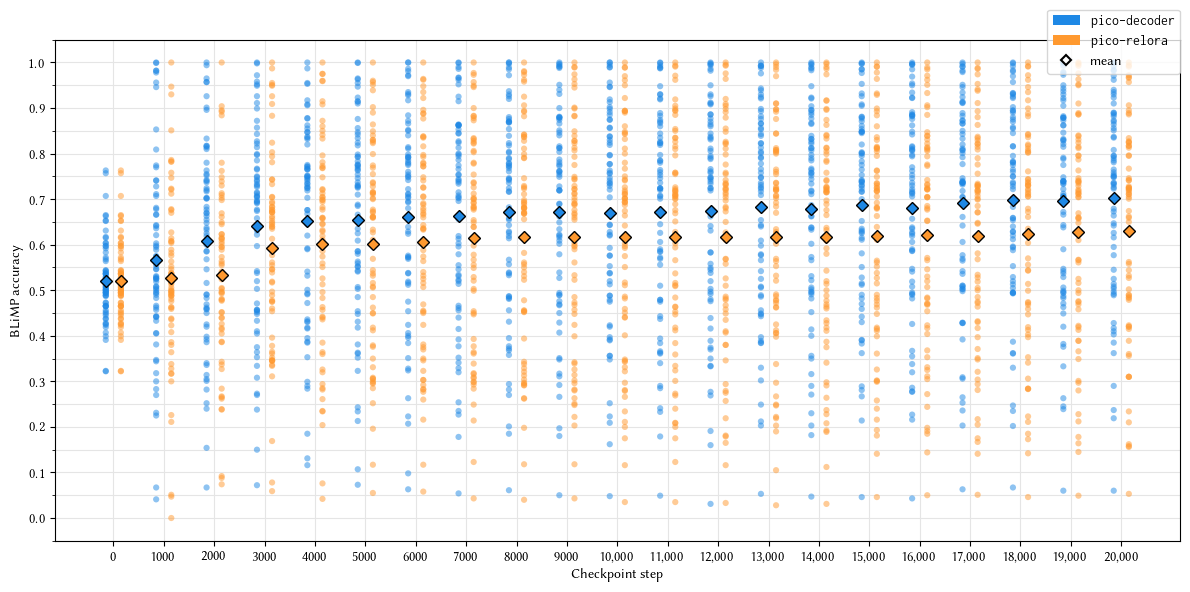

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))

labels = [r"\texttt{pico-decoder}", r"\texttt{pico-relora}"]
steps = np.arange(0, 21, 1) * 2

group_width = 0.9
point_jitter = 0.1  # Spread for strip plot
mid_offset = 0.6
colors = ["#1E88E5", "#FF992F"]
LINE_WEIGHT = 1

positions = []
for i in steps:
    positions.extend([i - mid_offset / 2, i + mid_offset / 2])

# Strip plot
for idx, (ts, pos) in enumerate(zip(uid_data, positions)):
    color = colors[idx % 2]
    # Add random horizontal jitter
    # jitter = np.random.uniform(-point_jitter, point_jitter, size=len(ts))
    jitter = np.zeros(len(ts))

    ax.scatter(
        pos + jitter,
        ts,
        color=color,
        alpha=0.5,  # Transparency
        s=20,
        edgecolor="none",
        zorder=3,
    )

    # Plot mean marker
    ax.plot(
        pos,
        np.mean(ts),
        marker="D",
        markersize=6,
        markerfacecolor=color,
        markeredgecolor="black",
        markeredgewidth=1,
        zorder=5,
        linestyle="None",
    )


# Axes labels and ticks
ax.set_ylabel("BLiMP accuracy")
ax.set_xticks(steps, labels=[f"{(i * 1000):,}" if i >= 10 else str(i * 1000) for i in range(0, 21)])
ax.set_xlabel(r"Checkpoint step")

ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_formatter(NullFormatter())
ax.grid(which="both", axis="both", color="#E5E5E5")

# Legend
legend_elements = [Patch(facecolor=color, label=label) for color, label in zip(colors, labels)]
legend_elements.append(
    Line2D(
        [0],
        [0],
        marker="D",
        markersize=5,
        markerfacecolor="white",
        markeredgecolor="black",
        markeredgewidth=1.5,
        label="mean",
        linestyle="",
    )
)
ax.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(1, 1.06), borderaxespad=0)

fig.tight_layout()
fig.savefig(f"../graphs/{SCALE}_blimp_strip.pdf")
fig.show()

# Load data for phenomenon plots

In [5]:
from collections import defaultdict

blimp_uid_to_phenomenon = {
    # Anaphor Agreement
    "anaphor_gender_agreement": "Anaphor Agreement",
    "anaphor_number_agreement": "Anaphor Agreement",
    "animate_subject_passive": "Anaphor Agreement",
    "animate_subject_trans": "Anaphor Agreement",
    # Argument Structure
    "causative": "Argument Structure",
    "drop_argument": "Argument Structure",
    "inchoative": "Argument Structure",
    "intransitive": "Argument Structure",
    "passive_1": "Argument Structure",
    "passive_2": "Argument Structure",
    "transitive": "Argument Structure",
    # Binding
    "principle_A_c_command": "Binding",
    "principle_A_case_1": "Binding",
    "principle_A_case_2": "Binding",
    "principle_A_domain_1": "Binding",
    "principle_A_domain_2": "Binding",
    "principle_A_domain_3": "Binding",
    "principle_A_reconstruction": "Binding",
    # Control/Raising
    "existential_there_object_raising": "Control/Raising",
    "existential_there_subject_raising": "Control/Raising",
    "tough_vs_raising_1": "Control/Raising",
    "tough_vs_raising_2": "Control/Raising",
    "expletive_it_object_raising": "Control/Raising",
    # Determiner-Noun Agreement
    "determiner_noun_agreement_1": "Determiner-Noun Agreement",
    "determiner_noun_agreement_2": "Determiner-Noun Agreement",
    "determiner_noun_agreement_irregular_1": "Determiner-Noun Agreement",
    "determiner_noun_agreement_irregular_2": "Determiner-Noun Agreement",
    "determiner_noun_agreement_with_adj_1": "Determiner-Noun Agreement",
    "determiner_noun_agreement_with_adjective_1": "Determiner-Noun Agreement",  # appears like this too
    "determiner_noun_agreement_with_adj_2": "Determiner-Noun Agreement",
    "determiner_noun_agreement_with_adj_irregular_1": "Determiner-Noun Agreement",
    "determiner_noun_agreement_with_adj_irregular_2": "Determiner-Noun Agreement",
    # Ellipsis
    "ellipsis_n_bar_1": "Ellipsis",
    "ellipsis_n_bar_2": "Ellipsis",
    # Filler-Gap
    "wh_questions_object_gap": "Filler-Gap",
    "wh_questions_subject_gap": "Filler-Gap",
    "wh_questions_subject_gap_long_distance": "Filler-Gap",
    "wh_vs_that_no_gap": "Filler-Gap",
    "wh_vs_that_no_gap_long_distance": "Filler-Gap",
    "wh_vs_that_with_gap": "Filler-Gap",
    "wh_vs_that_with_gap_long_distance": "Filler-Gap",
    # Irregular Forms
    "irregular_past_participle_adjectives": "Irregular Forms",
    "irregular_past_participle_verbs": "Irregular Forms",
    # Island Effects
    "adjunct_island": "Island Effects",
    "complex_NP_island": "Island Effects",
    "coordinate_structure_constraint_complex_left_branch": "Island Effects",
    "coordinate_structure_constraint_object_extraction": "Island Effects",
    "left_branch_island_echo_question": "Island Effects",
    "left_branch_island_simple_question": "Island Effects",
    "sentential_subject_island": "Island Effects",
    "wh_island": "Island Effects",
    # NPI Licensing
    "matrix_question_npi_licensor_present": "NPI Licensing",
    "npi_present_1": "NPI Licensing",
    "npi_present_2": "NPI Licensing",
    "only_npi_licensor_present": "NPI Licensing",
    "only_npi_scope": "NPI Licensing",
    "sentential_negation_npi_licensor_present": "NPI Licensing",
    "sentential_negation_npi_scope": "NPI Licensing",
    # Quantifiers
    "existential_there_quantifiers_1": "Quantifiers",
    "existential_there_quantifiers_2": "Quantifiers",
    "superlative_quantifiers_1": "Quantifiers",
    "superlative_quantifiers_2": "Quantifiers",
    # Subject-Verb Agreement
    "distractor_agreement_relational_noun": "Subject-Verb Agreement",
    "distractor_agreement_relative_clause": "Subject-Verb Agreement",
    "irregular_plural_subject_verb_agreement_1": "Subject-Verb Agreement",
    "irregular_plural_subject_verb_agreement_2": "Subject-Verb Agreement",
    "regular_plural_subject_verb_agreement_1": "Subject-Verb Agreement",
    "regular_plural_subject_verb_agreement_2": "Subject-Verb Agreement",
}


phenomena = sorted(list(set(blimp_uid_to_phenomenon.values())))


def group_by_phenomenon(data: dict):
    res = defaultdict(list)
    for uid, val in data["by_uid"].items():
        res[blimp_uid_to_phenomenon[uid]].append(val)
    return res

In [6]:
# Load all BLiMP data -- by phenomenon
phen_data = []
STEP = 20_000

baseline_data = load_blimp_data(Path(f"blimp_results_{SCALE}/step_{STEP}.json"))
base_phenoms = group_by_phenomenon(baseline_data)

relora_data = load_blimp_data(Path(f"relora-{SCALE}-eval/step_{STEP}.json"))
relora_phenoms = group_by_phenomenon(relora_data)

for p in phenomena:
    phen_data.append(base_phenoms[p])
    phen_data.append(relora_phenoms[p])

/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_11111/2862881294.py:97: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


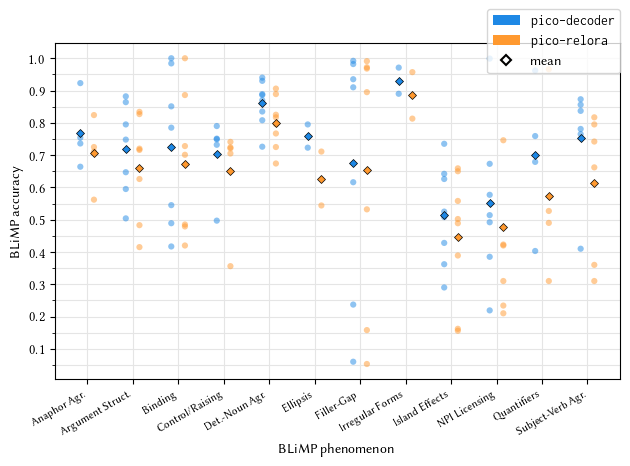

In [7]:
fig, ax = plt.subplots()

labels = [r"\texttt{pico-decoder}", r"\texttt{pico-relora}"]

positions = []

ticks = np.arange(len(phenomena))

group_width = 0.9  # Total width for each group of boxes
box_width = 0.2
box_offset = 0.05
real_offset = (box_width / 2) + box_offset
positions = []

for i in ticks:
    positions.extend([i - real_offset, i + real_offset])

# Set colors for boxes
colors = ["#1E88E5", "#FF992F"]

for idx, (phen, pos) in enumerate(zip(phen_data, positions)):
    jitter = np.zeros(len(phen))

    color = colors[idx % 2]

    ax.scatter(
        pos + jitter,
        phen,
        color=color,
        alpha=0.5,  # Transparency
        s=20,
        edgecolor="none",
        zorder=3,
    )

    ax.plot(
        pos,
        np.mean(phen),
        marker="D",
        markersize=4,
        markerfacecolor=color,
        markeredgecolor="black",
        markeredgewidth=0.5,
        zorder=6,
    )

ax.set_ylabel("BLiMP accuracy")


def shorten_label(label: str):
    label = label.replace("Agreement", "Agr.")
    label = label.replace("Determiner", "Det.")
    label = label.replace("Structure", "Struct.")
    return label


ax.set_xticks(
    ticks,
    labels=[shorten_label(lab) for lab in phenomena],
    fontsize=8,
    rotation=30,
    ha="right",
    rotation_mode="default",
)

ax.set_xlabel(r"BLiMP phenomenon")

ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}"))
ax.yaxis.set_minor_formatter(NullFormatter())


ax.grid(which="both", axis="both", color="#E5E5E5")

legend_elements = [Patch(facecolor=color, label=label) for color, label in zip(colors, labels)]

legend_elements.append(
    Line2D(
        [0],
        [0],
        marker="D",
        markersize=5,
        markerfacecolor="white",
        markeredgecolor="black",
        markeredgewidth=1.5,
        label="mean",
        linestyle="",
    )
)

# Add the legend
ax.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(1, 1.1), borderaxespad=0)

fig.tight_layout()
fig.savefig(f"../graphs/{SCALE}_blimp_phenom_strip.pdf")
fig.show()